<h2 style="background-color:orange;color:black">Evolution</h2>
This notebook is aimed at exploring time evolution. Not the Darwinian kind, the quantum kind. <br>
The time evolution operator in quantum mechanics is given by,
\begin{align}
\hat U(0,t) = \mathcal T \exp\left(-\frac{i}{\hbar}\int_0^t H(\tau)d\tau\right)
\end{align}
In the Schrodinger picure, the operator acts on a state to evolve it from time $0$ to time $t$. In the Heisenberg picture, the states are constant in time, while the operators evolve in time. The problem with this operator is that it involves time ordred integrals, which is not easy numerically. We can look at two approaches:<br>
<li>Calculate time ordered expnentials using Magnus expansion.</li> 
<li>Abandon evolution operator and solve the Schrodinger equation using Crank-Nicolson or RK4</li> 
<h3>Magnus expansion</h3>    
\begin{align}
    U(t) &= \exp\left( \Omega(t) \right) \\
    \Omega(t) &= \Omega_1(t) + \Omega_2(t) + \Omega_3(t) + \cdots \\
    \Omega_1(t) &= -i \int_0^t H(\tau_1)\, d\tau_1 \\
    \Omega_2(t) &= -\frac{1}{2} \int_0^t d\tau_1 \int_0^{\tau_1} d\tau_2 \, [H(\tau_1), H(\tau_2)] \\
    \Omega_3(t) &= \frac{i}{6} \int_0^t d\tau_1 \int_0^{\tau_1} d\tau_2 \int_0^{\tau_2} d\tau_3 \, \Big( [H(\tau_1),[H(\tau_2),H(\tau_3)]] + [H(\tau_3), [H(\tau_2), H(\tau_1)]] \Big)
\end{align}

<h3>RK4 method</h3>
To solve $\frac{dy}{dx} = f(x, y)$:
\begin{align}
    y_{i+1} &= y_i + \frac{1}{6}(k_1 + 2k_2 +2k_3 + k_4)h\\
    k_1 &= f(x_i, y_i)\\
    k_2 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_1h)\\
    k_3 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_2h\\
    k_4 &= f(x_i + h, y_i + k3h)
\end{align}
Let's try it out!

<H2>RK4</H2>

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.integrate as integrate

sigmax = np.matrix([[0, 1],[1, 0]])
sigmay = np.matrix([[0, -1j],[1j, 0]])
sigmaz = np.matrix([[1, 0j],[0, -1]])


def H(w1, phi1, w2, phi2, m, t):
    return (np.sin(w1*t + phi1)*sigmax + np.sin(w2*t + phi2)*sigmay + (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))*sigmaz)

def eigv1(w1, phi1, w2, phi2, m, t):
    d1 = np.sin(w1*t + phi1)
    d2 = np.sin(w1*t + phi1)
    d3 = (m - np.cos(w1*t + phi1) - np.cos(w2*t + phi2))
    d = np.sqrt(d1**2 + d2**2 + d3**2)
    return (1/(np.sqrt(2*d*(d+d3))))*np.matrix([[d1 - 1j * d2], [d + d3]])
    
def rk4step(t0, h):
    v = eigv1(w1, phi1, w2, phi2, m, t0)
    k1 = -1j * H(w1, phi1, w2, phi2, m, t0) @ v
    k2 = -1j * H(w1, phi1, w2, phi2, m, t0 + h/2) @ (v + k1*h/2)
    k3 = -1j * H(w1, phi1, w2, phi2, m, t0 + h/2) @(v + k2*h/2)
    k4 = -1j * H(w1, phi1, w2, phi2, m, t0 + h) @ (v + k3*h)
    return v + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

In [3]:
w1 = 0.1
g = np.sqrt(2)
w2 = g*w1
m = 1
phi1 = np.pi/10
phi2 = 0

In [37]:
h = 0.1
ti = 0
band1 = []
band2 = []
tvals = []
while(ti<1e4):
    v1 = eigv1(w1, phi1, w2, phi2, m, ti)
    v2 = np.conjugate(v1)
    e1 = v1.H @ H(w1, phi1, w2, phi2, m, ti) @ v1
    e2 = v2.H @ H(w1, phi1, w2, phi2, m, ti) @ v2
    band1.append(np.real(e1[0,0]))
    band2.append(np.real(e2[0,0]))
    tvals.append(ti)
    ti = ti + h

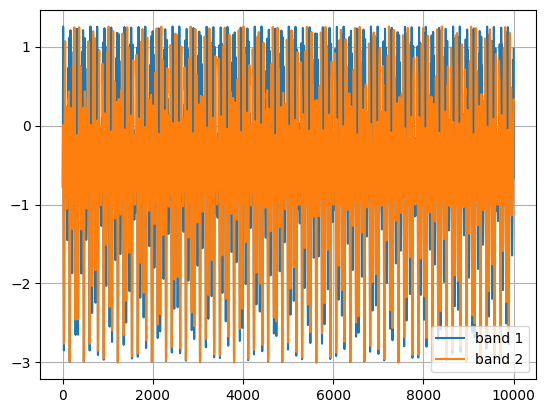

In [38]:
plt.plot(tvals, band1)
plt.plot(tvals, band2)
plt.legend(['band 1', 'band 2'])
plt.grid()
plt.show()